In [13]:
%pylab inline
import numpy as np
import scipy.fftpack as fftpack
import scipy.io as io
import scipy.signal as signal
import scipy.stats as stats
import matplotlib.pylab as plt
import json_tricks
import glob
import os
import sys
import h5py
import odo
import deepdish
import time

Populating the interactive namespace from numpy and matplotlib


/home/orcasha/anaconda2/envs/py35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'cond', 'fftpack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## TO DO:

Figure out how to shrink 3d to 1d vector - Idea: ratio of l / r central channels, split epochs into rows
Add identifier row
Loop over conditions / participants creating a n x m matrix with col 1 as identifier.


### Required functions:

#### To do:
* Resample    
    * Args: Resample rate (Hz)
        
#### Completed:
* Reference / Re-reference    
    * Args: Existing ref?, Reference ch / av.

* Samples to time vector    
    * Ar
    
* Reference / Re-reference
    * Args: Existing ref?, Reference ch / av.
        
* Filter (FFT? Butterworth?)    
    * Args: low, high, window (if fft) / order (if BW)
        
* Channel select
    * Args: Channel list (10/20 nomenclature), channel name / number dict, data

In [5]:
def eeg_chansel(ch_list, chan_dict, data):

    '''
    Creates numpy array of selected channel's data and list of selected
    eeg channels.
    ch_list: List of channels (in 10 / 20 nomenclature) to select
    chan_dict: Dictionary of channel names / numbers
    data: Data to select channels
    '''

    nchans = len(ch_list)
    dshape = data.shape

    #Preallocate zeros array / matrix
    chan_data = np.zeros([nchans, dshape[1]])

    #Populate array / matrix
    for n, ch in enumerate(ch_list):
        ch_r = int(chan_dict[ch]) - 1
        chan_data[n, :] = data[ch_r, :]

    return(ch_list, chan_data)


def eeg_samples_to_time(tmin, tmax, sr):
    '''
    Calculates a time vector from tmin to tmax.
    Inputs: 
    
    tmin - Minimum time point
    tmax - Maximum time point
    sr - Sampling rate
    '''
    
    steps = 1000 / sr
    time_vec = np.round(np.arange(tmin, tmax, steps), decimals = 3)
    
    return(steps, time_vec)


def eeg_reref(data, ch):
    '''
    Re-reference eeg data (subtract ref channel from all eeg).
    Valid options = 1:64 or av (for average reference)
    '''
    
    data = data[0:63]
    
    re_ref = data.copy()
    r,c = data.shape
    if type(ch) == int:
        ref_sig = data[ch - 1, :]
        for x in range(0, r):
            re_ref[x] = re_ref[x] - ref_sig
    
    elif ch == 'av':
        ref_sig = np.mean(data, axis = 0)
        for x in range(0, r):
            re_ref[x] = re_ref[x] - ref_sig
    else:
        raise NameError('Ref channel not valid. Please use an integer or av to indicate reference channel.')
            
    return(ref_sig, re_ref)


def eeg_zscore(data):
    '''
    Standardise data (m = 0, sd = 1)
    '''
    
    zdata = np.zeros_like(data)
    r,c = zdata.shape
    
    for x in range(0, r):
        zdata[x] = (data[x] - np.mean(data[x])) / np.std(data[x])
        
    return(zdata)

def eeg_demean(data):
    '''
    Standardise data (m = 0, sd = 1)
    '''
    
    dmdata = np.zeros_like(data)
    r,c = dmdata.shape
    
    for x in range(0, r):
        dmdata[x] = (data[x] - np.mean(data[x]))
    
    return(dmdata)



def eeg_filt(data, highpass = None, lowpass = None, ford = 4, sr = 1):
    '''
    Filter signals using a buttworth n order filter
    Select either a low, high or bandpass filter depending
    on input frequencies to filter.
    
    NOTE: Default sampling rate is 1 Hz. 
    '''
    nyq = 0.5 * sr # Calculate nyquist
    hp = None
    lp = None
    
    #Normalised frequencies (freq / nyquist)
    if highpass != None:
        hp = highpass / nyq
        
    if lowpass != None:
        lp = lowpass / nyq
    
    #No filter
    if hp == None and lp == None:
        print('\n***WARNING! NO FILTER APPLIED!***\n')
        return(data)
    
    #High pass filter
    if hp != None and lp == None:
        b, a = signal.butter(ford, hp, btype = 'high')
        filt_data = signal.filtfilt(b, a, data)
        return(filt_data)
            
    #Low pass filter        
    if hp == None and lp != None:
        b, a = signal.butter(ford, lp, btype = 'low')
        filt_data = signal.filtfilt(b, a, data)
        return(filt_data)
    
    #Bandpass filter
    else:
        b, a = signal.butter(ford, [hp, lp], btype = 'bandpass')
        filt_data = signal.filtfilt(b, a, data)
        return(filt_data)

def eeg_epoch(data, event, pre, post, sr):
    '''
    Epochs data using event list
    '''
    pre = pre / 1000 #Convert to seconds
    pre_samples = int(abs(pre * sr))
    post = post / 1000 #Ditto
    post_samples = int(abs(post * sr))

    d_ch, d_vect = data.shape
    idx = np.where(event == 1)[0]
    n_epo = len(idx)
    epo_vect = int(pre_samples + post_samples)

    #Preallocate matrix
    epo_mat = np.zeros([d_ch, epo_vect, n_epo])

    #Loop through

    for n, zero_point in enumerate(idx):
        zero_point += 1
        epo_mat[:, :, n] = data[:, zero_point - pre_samples : zero_point + post_samples]
    
    return(idx, epo_mat)
    
    
def eeg_epo_fft(data, sr):
    fft_data = np.zeros_like(data)
    r, c, eps = fft_data.shape
    steps = 1 / sr
    fft_res = fftpack.fftfreq(c, steps)
    
    
    for e in range(0, eps): 
        for x in range(0, r):
            fft_data[x, :, e] = fftpack.fft(data[x, :, e])
    return(fft_res, fft_data)

In [6]:
data_dir = os.path.join(os.getcwd(), 'mat_data')
subj_files = glob.glob(data_dir + '/*.mat')
subj_files.sort()

save_path = '/mnt/data/eeg_preproc/'

try:
    os.mkdir(save_path)
except:
    print('Save path {} already exists'.format(save_path))

Save path /mnt/data/eeg_preproc/ already exists


In [7]:
data_conds = {'movement_left' : 1, 'movement_right' : 2, 'imagery_left' : 3, 'imagery_right' : 4}

In [1]:
subj_errors = []

for subj_file in subj_files:
    
    subj = os.path.split(subj_file)[1].split('.')[0]
    print('Pre-processing subject {}'.format(subj))
    
    try:
        eeg_raw = io.loadmat(subj_file)['eeg']

        #Matlab structure is represented as an array of 0,0,f (where f is the structure field)
        field_names = [eeg_raw.dtype.descr[x][0] for x in range(0, len(eeg_raw.dtype.descr))] 

        #Get matlab field names
        eeg_dict = {key: np.squeeze(eeg_raw[0][0][f]) for f, key in enumerate(field_names)} 

        #Create data dictionary

        #Get nice to know info (sampling rate, epoch times)
        sr = eeg_dict['srate']
        trial_len = eeg_dict['frame']

        #Split noise conditions
        noise_list = ['blink', 'eye_ud', 'eye_lr', 'jaw', 'head_lr']

        for n, d in enumerate(eeg_dict['noise']):
            eeg_dict[noise_list[n]] = d

        del eeg_dict['noise'] #Remove noise

        #Read channel list, clean, remove header and add to eeg dictionary

        ch_csv = os.path.join(os.getcwd(), 'chan_list.csv')
        eeg_dict['ch_dict'] = dict([line.replace('\n','').split(',') for line in open(ch_csv)][1:])

        save_dict = {}
        for cond in data_conds.keys():
            print('Processing {} data'.format(cond))

            #Add reference channel
            eeg_dict[cond + '_ref_sig'], eeg_dict[cond + '_re_ref'] = eeg_reref(eeg_dict[cond], ch = 'av')

            #Zscore and demean data
            eeg_dict[cond + '_zscore'] = eeg_zscore(eeg_dict[cond + '_re_ref'])
            eeg_dict[cond + '_demean'] = eeg_demean(eeg_dict[cond + '_re_ref'])

            #Filter data, epoch
            eeg_dict[cond + '_filt'] = eeg_filt(eeg_dict[cond + '_zscore'], 2, None, 5, sr = sr)
            if 'movement' in cond:
                eeg_dict[cond + '_epo_idx'], eeg_dict[cond + '_epo'] = eeg_epoch(eeg_dict[cond + '_filt'], eeg_dict['movement_event'], eeg_dict['frame'][0], eeg_dict['frame'][1], sr)
            elif 'imagery' in cond:
                eeg_dict[cond + '_epo_idx'], eeg_dict[cond + '_epo'] = eeg_epoch(eeg_dict[cond + '_filt'], eeg_dict['imagery_event'], eeg_dict['frame'][0], eeg_dict['frame'][1], sr)
            else:
                print('Rest condition') #Figure out what to do with rest

            #FFT data    
            eeg_dict[cond + '_res'], eeg_dict[cond + '_epo_fft'] = eeg_epo_fft(eeg_dict[cond + '_epo'], sr)

        dict_list = ['ch_dict', 'movement_left_epo_fft', 'movement_right_epo_fft', 'imagery_left_epo_fft', 'imagery_right_epo_fft']
        for d in dict_list:
            save_dict[d] = eeg_dict[d]

        with open(save_path + '/' + subj + '_eeg.json', 'w') as json_file:
            print('Writing {} to json'.format(subj))
            json_tricks.dump(save_dict, json_file)
            
    except:
        subj_errors.append(subj)

NameError: name 'subj_files' is not defined

In [ ]:
subj_errors = []

subj_file = subj_files[0]

subj = os.path.split(subj_file)[1].split('.')[0]
print('Pre-processing subject {}'.format(subj))

eeg_raw = io.loadmat(subj_file)['eeg']

#Matlab structure is represented as an array of 0,0,f (where f is the structure field)
field_names = [eeg_raw.dtype.descr[x][0] for x in range(0, len(eeg_raw.dtype.descr))] 

#Get matlab field names
eeg_dict = {key: np.squeeze(eeg_raw[0][0][f]) for f, key in enumerate(field_names)} 

#Create data dictionary

#Get nice to know info (sampling rate, epoch times)
sr = eeg_dict['srate']
trial_len = eeg_dict['frame']

#Split noise conditions
noise_list = ['blink', 'eye_ud', 'eye_lr', 'jaw', 'head_lr']

for n, d in enumerate(eeg_dict['noise']):
    eeg_dict[noise_list[n]] = d

del eeg_dict['noise'] #Remove noise

#Read channel list, clean, remove header and add to eeg dictionary

ch_csv = os.path.join(os.getcwd(), 'chan_list.csv')
eeg_dict['ch_dict'] = dict([line.replace('\n','').split(',') for line in open(ch_csv)][1:])

save_dict = {}
for cond in data_conds.keys():
    print('Processing {} data'.format(cond))

    #Add reference channel
    eeg_dict[cond + '_ref_sig'], eeg_dict[cond + '_re_ref'] = eeg_reref(eeg_dict[cond], ch = 'av')

    #Zscore and demean data
    eeg_dict[cond + '_zscore'] = eeg_zscore(eeg_dict[cond + '_re_ref'])
    eeg_dict[cond + '_demean'] = eeg_demean(eeg_dict[cond + '_re_ref'])

    #Filter data, epoch
    eeg_dict[cond + '_filt'] = eeg_filt(eeg_dict[cond + '_zscore'], 2, None, 5, sr = sr)
    if 'movement' in cond:
        eeg_dict[cond + '_epo_idx'], eeg_dict[cond + '_epo'] = eeg_epoch(eeg_dict[cond + '_filt'], eeg_dict['movement_event'], eeg_dict['frame'][0], eeg_dict['frame'][1], sr)
    elif 'imagery' in cond:
        eeg_dict[cond + '_epo_idx'], eeg_dict[cond + '_epo'] = eeg_epoch(eeg_dict[cond + '_filt'], eeg_dict['imagery_event'], eeg_dict['frame'][0], eeg_dict['frame'][1], sr)
    else:
        print('Rest condition') #Figure out what to do with rest

    #FFT data    
    eeg_dict[cond + '_res'], eeg_dict[cond + '_epo_fft'] = eeg_epo_fft(eeg_dict[cond + '_epo'], sr)

dict_list = ['ch_dict', 'movement_left_epo_fft', 'movement_right_epo_fft', 'imagery_left_epo_fft', 'imagery_right_epo_fft']
for d in dict_list:
    save_dict[d] = eeg_dict[d]

print('Saving file for {}'.format(subj))

t1 = time.time()
deepdish.io.save(os.path.join(save_path, 'test.hdf5'), save_dict)
t2 = time.time() - t1

print('Save complete in {}'.format(t2))


# f = h5py.File(os.path.join(save_path, 'test.hdf5'), 'w')
# q = f.create_group(save_dict)
# q.close()
#     with open(save_path + '/' + subj + '_eeg.json', 'w') as json_file:
#         print('Writing {} to json'.format(subj))
#         json_tricks.np.dumps(save_dict, json_file)


Pre-processing subject s01
Processing imagery_left data
Processing movement_left data
Processing movement_right data
Processing imagery_right data
Saving file for s01


In [27]:
# f = h5py.File(os.path.join(save_path, 'test.hdf5'), 'w')
# q = f.create_dataset(save_dict)
# q.close()

# f = h5py.File(os.path.join(save_path, 'test.hdf5'), 'r')
# f.close()

OSError: Unable to create file (Unable to truncate a file which is already open)

In [9]:
subj_errors
with open('subj_errors.txt', 'w') as txtfile:
    txtfile.write(str(subj_errors))

In [22]:
with open('test.json', 'w') as fp:
    json_tricks.dump(save_dict, fp, conv_str_byte = True)

In [26]:
x = json_tricks.load('test.json', conv_str_byte = True)

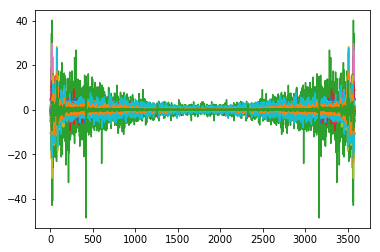

In [31]:
plt.plot(x['imagery_left_epo_fft'][:,:,0].T);